In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np
from dataset import *
from model import *
import datetime
import scipy
import librosa
import os
import generated.fragment_resolver_pb2 as fragment_resolver

device = tf.config.experimental.list_physical_devices('GPU')[0]
tf.config.experimental.set_memory_growth(device, True)
tf.config.run_functions_eagerly(False)

# tf.keras.backend.set_floatx('float32')

In [3]:
def plot_data(samples, num_grid_cells=None, fc=(1,0,0), *yolo_outputs):
    fig = plt.figure()
    ax = fig.gca()
    color_alpha_per_fragment = 0.5 / len(yolo_outputs)
    
    encoded_fragments = yolo_decoder(tf.constant(list(yolo_outputs))).merge_dims(0, 1)  
    fragment_protos = fragment_decoder.decode_fragments_to_proto(encoded_fragments)[0].numpy()
    audio_fragments = fragment_resolver.FragmentResolverModelResponse()
    audio_fragments.ParseFromString(fragment_protos)
    
    for fragment in sorted(audio_fragments.fragments, key=lambda fragment: fragment.startUs):
#         fragment_start_offset = int(fragment.startUs / (1e6 / sample_rate))
#         fragment_end_offset = int(fragment.endUs / (1e6 / sample_rate))
#         fragment_duration = fragment_end_offset - fragment_start_offset
        fragment_start_ms = fragment.startUs / 1000
        fragment_end_ms = fragment.endUs / 1000
        fragment_duration_ms = fragment_end_ms - fragment_start_ms
        print(fragment)
        rect = plt.Rectangle((fragment_start_ms, -0.5), fragment_duration_ms, 1, fc=(*fc, color_alpha_per_fragment))
        ax.add_patch(rect)
    
    ax.plot(np.arange(0, samples.shape[0] / sample_rate * 1000, 1 / sample_rate * 1000), samples, zorder=-1)
    if num_grid_cells:
        for i_cell in range(num_grid_cells):
            rect = plt.Rectangle((i_cell * samples.shape[0] / sample_rate * 1000 / num_grid_cells, -1), samples.shape[0] / sample_rate * 1000 / num_grid_cells, 2, ec='black', fc='none')
            ax.add_patch(rect)
            
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Amplitude')
            
def plot_stft(samples, fs):
    nfft = 1024
    nperseg = 1024
    noverlap = nperseg-16
    samples = np.squeeze(samples, axis=-1)
    f, t, stft = scipy.signal.stft(samples, fs, nperseg=nperseg, noverlap=noverlap, nfft=nfft)
    print(stft.shape)
    threshold_ghz = np.arange(len(f)) < 64
    f = f[threshold_ghz]
    threshold_ghz = np.transpose(np.tile(threshold_ghz, (t.shape[0], 1)))
    stft = np.reshape(stft[threshold_ghz], (f.shape[0], t.shape[0]))
    stft = np.abs(stft)
    stft = librosa.power_to_db(stft, amin=1e-5, top_db=80.0)
    fig = plt.figure()
    ax = fig.gca()
    stft = scipy.ndimage.gaussian_filter(stft, sigma=(9, 0))
    pcm = ax.pcolormesh(t * 1000, f, stft, shading='gouraud', cmap='inferno')
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Frequency (Hz)')
    cbar = fig.colorbar(pcm, ax=ax)
    cbar.ax.set_ylabel('Amplitude (dB)')
    
def is_data():
    global data
    try:
        data = data
        return True
    except NameError:
        return False

class EpochCounter(tf.keras.callbacks.Callback):
    def __init__(self):
        self.epoch_counter = 0
        
    def on_epoch_end(self, epoch, logs=None):
        self.epoch_counter += 1
        print(f'Epoch counter = {self.epoch_counter}')

In [4]:
cwd = os.getcwd()
seed = 4221
batch_size = 8
sample_rate = 32758
min_duration_sec = 5
max_shift_duration_sec = 2
num_grid_cells = 20
# yolo_encoding_type = 'START_DURATION'
yolo_encoding_type = 'CENTER_DURATION'
fragments_dtype = tf.float32.name

input_length = int(sample_rate * min_duration_sec)
model_params = {
    fragment_resolver.ResolvedTransformer.Type.SILENCE: {
        'silenceDurationUs': LinearTransformerNormalizerLayer(5e5, in_dtype=tf.int64)
    },
#     fragment_resolver.ResolvedTransformer.Type.TYPE2: {
#         'typeType2Param2': LinearTransformerNormalizerLayer(100, in_dtype=tf.int64), 
#           'typeType2Param3': LinearTransformerNormalizerLayer(100, in_dtype=tf.int64), 
#           'typeType2Param4': LinearTransformerNormalizerLayer(100, in_dtype=tf.int64)
#     },
#     fragment_resolver.ResolvedTransformer.Type.TYPE3: {
#         'typeType3Param5': LinearTransformerNormalizerLayer(100, in_dtype=tf.int64), 
#         'typeType3Param6': LinearTransformerNormalizerLayer(100, in_dtype=tf.int64)
#     }
}

with open(os.path.join(cwd, 'generated', 'descriptor_set.desc'), 'rb') as desc_file:
    protobuf_descriptor = desc_file.read()
data_path = os.path.join(cwd, '..', 'data', 'clips', 'labeled')
train_data_path = os.path.join(data_path, 'train')
val_data_path = os.path.join(data_path, 'train')

train_data_generator = AudioDataJsonToProtoGenerator(train_data_path)
val_data_generator = AudioDataJsonToProtoGenerator(val_data_path)
fragment_encoder = ProtoFragmentBatchEncoderLayer(sample_rate, model_params, protobuf_descriptor, fragments_dtype)
fragment_decoder = ProtoFragmentBatchDecoderLayer(sample_rate, model_params, protobuf_descriptor)
audio_decoder = AudioDecoder(sample_rate)
# Prepare default padding transformer
default_padding_transformer = fragment_resolver.ResolvedTransformer() 
default_padding_transformer.type = fragment_resolver.ResolvedTransformer.Type.SILENCE
default_padding_transformer.silenceDurationUs = 0
default_padding_transformer = default_padding_transformer.SerializeToString()
default_padding_transformer = fragment_encoder.encode_transformers_to_tensor(default_padding_transformer)[0]

data_augmenter = AudioDataShiftAugmenterLayer(sample_rate, max_shift_duration_sec, seed)
data_padder = AudioDataPadderLayer(sample_rate, min_duration_sec, min_duration_sec * 0.01, default_padding_transformer)
data_splitter = AudioDataUniformSplitterLayer(sample_rate, min_duration_sec, min_duration_sec / num_grid_cells * 4, min_duration_sec * 0.01, False)
yolo_encoder = YoloOutputEncoderLayer(num_grid_cells, input_length, yolo_encoding_type, False)
yolo_decoder = YoloOutputDecoderLayer(input_length, 0.5, yolo_encoding_type, fragments_dtype)
yolo_validator = YoloOutputValidatorLayer()

# train_source_dataset = tf.data.Dataset\
#             .from_generator(train_data_generator.generate, 
#                             output_signature=(
#                                 tf.TensorSpec(shape=(None), dtype=tf.string),
#                                 tf.TensorSpec(shape=(None), dtype=tf.string)
#                             ))
train_source_dataset = tf.data.experimental.load(os.path.join(data_path, 'train_ds_enc_' + yolo_encoding_type.lower()))
# print('Train source dataset loaded')
train_dataset = train_source_dataset\
            .cache()\
            .repeat()\
            .map(lambda audio_path, fragments_proto: (audio_path, fragment_encoder.encode_fragments_to_tensor(fragments_proto)))\
            .map(lambda audio_path, fragments: (audio_decoder.decode(audio_path), fragments))\
            .map(data_augmenter.augment_samples)\
            .map(data_padder.pad_samples)\
            .flat_map(data_splitter.split_into_frames)\
            .map(lambda samples, fragments: (samples, yolo_encoder.encode(fragments)))\
            .filter(lambda samples, yolo_output: yolo_validator.is_valid(yolo_output))\
            .shuffle(batch_size * 8, seed, reshuffle_each_iteration=True)\
            .batch(batch_size)

# val_source_dataset = tf.data.Dataset\
#             .from_generator(val_data_generator.generate, 
#                             output_signature=(
#                                 tf.TensorSpec(shape=(None), dtype=tf.string),
#                                 tf.TensorSpec(shape=(None), dtype=tf.string)
#                             ))\
#             .map(lambda audio_path, fragments_proto: (audio_path, fragment_encoder.encode_fragments_to_tensor(fragments_proto)))\
#             .map(lambda audio_path, fragments: (audio_decoder.decode(audio_path), fragments))\
#             .map(data_padder.pad_samples)\
#             .flat_map(data_splitter.split_into_frames)\
#             .map(lambda samples, fragments: (samples, yolo_encoder.encode(fragments)))\
#             .filter(lambda samples, yolo_output: yolo_validator.is_valid(yolo_output))\
#             .cache()
val_source_dataset = tf.data.experimental.load(os.path.join(data_path, 'validation_ds_enc_' + yolo_encoding_type.lower()))
print('Validation source dataset loaded')
val_dataset = val_source_dataset.batch(batch_size)
            
data = list(val_dataset.take(1).as_numpy_iterator())[0]
data = list(zip(data[0], data[1]))
data

Validation source dataset loaded


[(array([[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.0049568 ],
         [0.00876785],
         [0.00444154]], dtype=float32),
  array([[1.        , 0.33600003, 0.0336    , 1.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        , 0.        ],
         [1.        , 0.8080001 , 0.06      , 1.        , 0.4       ],
         [0.        , 0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.  

In [5]:
model = YoloModel8(input_length, num_grid_cells, fragment_encoder.transformer_output_length)
display(model.summary())

train_results_filepath = os.path.join(cwd, '..', 'results', 'trained_models')
checkpoint_filepath = os.path.join(train_results_filepath, '7_2_cpt.h5')
epoch_ctr = EpochCounter()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 163790, 1)]  0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 163790, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
stft (STFT)                     (None, 10240, 32, 1) 0           lambda[0][0]                     
__________________________________________________________________________________________________
magnitude (Magnitude)           (None, 10240, 32, 1) 0           stft[0][0]                       
______________________________________________________________________________________________

None

In [6]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath,
            save_weights_only=True,
            monitor='val_bounds_metric',
            mode='min',
            save_best_only=True)

In [33]:
yolo_loss = YoloLossFunction(num_grid_cells, input_length, 
                {'l_cbf': 35.0, 'l_cubf': 35.0, 'l_isobj': 1.0, 'l_noobj': 0.5, 'l_class': 35.0}, yolo_encoding_type)

start_metric = YoloLossFunction(num_grid_cells, input_length,
                {'l_cbf': 1.0, 'l_cubf': 0.0, 'l_isobj': 0, 'l_noobj': 0, 'l_class': 0}, yolo_encoding_type, name='start_metric')
duration_metric = YoloLossFunction(num_grid_cells, input_length,
                {'l_cbf': 0.0, 'l_cubf': 1.0, 'l_isobj': 0, 'l_noobj': 0, 'l_class': 0}, yolo_encoding_type, name='duration_metric')
class_metric = YoloLossFunction(num_grid_cells, input_length,
                {'l_cbf': 0, 'l_cubf': 0, 'l_isobj': 0, 'l_noobj': 0, 'l_class': 1.0}, yolo_encoding_type, name='class_metric')
bounds_metric = YoloLossFunction(num_grid_cells, input_length,
                {'l_cbf': 1.0, 'l_cubf': 1.0, 'l_isobj': 0, 'l_noobj': 0, 'l_class': 0}, yolo_encoding_type, name='bounds_metric')

model.compile(
    loss=yolo_loss,
    metrics=[start_metric, duration_metric, class_metric, bounds_metric],
#     optimizer='adagrad'
#     optimizer='rmsprop'
#     optimizer='adam'
#     optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001)#, clipnorm=0.01)
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005)
#     optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001, centered=True)
)


In [37]:
num_epochs = 1000
while epoch_ctr.epoch_counter < num_epochs:
    try:
        model.fit(train_dataset, epochs=num_epochs, initial_epoch=epoch_ctr.epoch_counter, 
                  verbose=1, steps_per_epoch=640/batch_size,
                  validation_data=val_dataset, 
                  callbacks=[epoch_ctr, model_checkpoint_callback])
    except KeyboardInterrupt:
        break
    except Exception as e:
        print(e)
        break

Epoch 104/1000
17/80 [=====>........................] - ETA: 26s - loss: 6.4787 - start_metric: 0.0494 - duration_metric: 0.0348 - class_metric: 0.0791 - bounds_metric: 0.0842

<IPython.core.display.Javascript object>


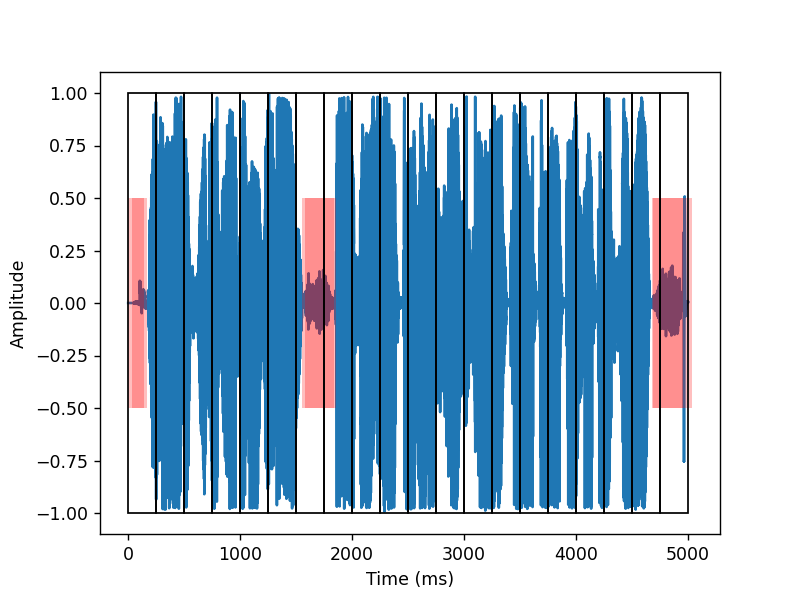

endUs: 167989
transformer {
}

startUs: 31167
endUs: 137371
transformer {
  silenceDurationUs: 138960
}

startUs: 1551987
endUs: 1852005
transformer {
  silenceDurationUs: 200000
}

startUs: 1575218
endUs: 1837230
transformer {
  silenceDurationUs: 186217
}

startUs: 4674583
endUs: 5034587
transformer {
  silenceDurationUs: 200000
}

startUs: 4690213
endUs: 4953507
transformer {
  silenceDurationUs: 219952
}



<IPython.core.display.Javascript object>


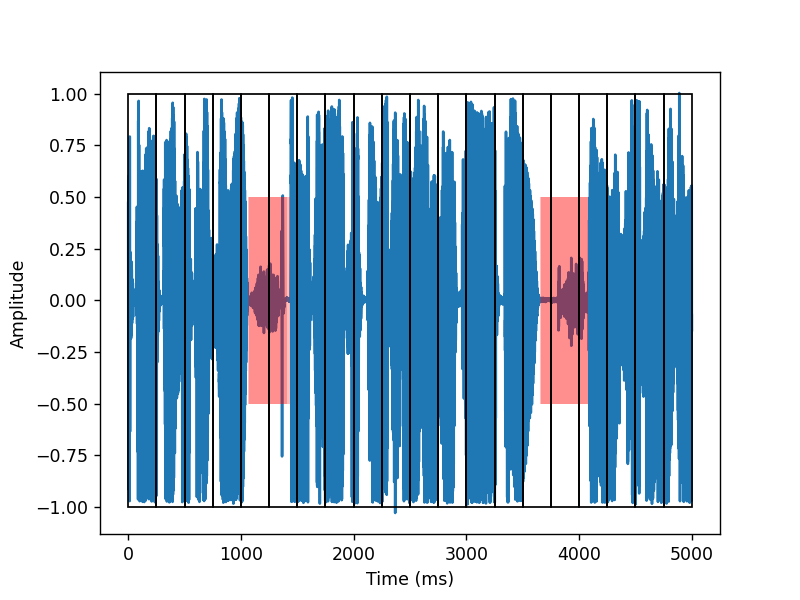

startUs: 1066823
endUs: 1411838
transformer {
  silenceDurationUs: 189217
}

startUs: 1075004
endUs: 1435008
transformer {
  silenceDurationUs: 200000
}

startUs: 3652268
endUs: 4076256
transformer {
  silenceDurationUs: 200000
}

startUs: 3664784
endUs: 4075676
transformer {
  silenceDurationUs: 218883
}



<IPython.core.display.Javascript object>


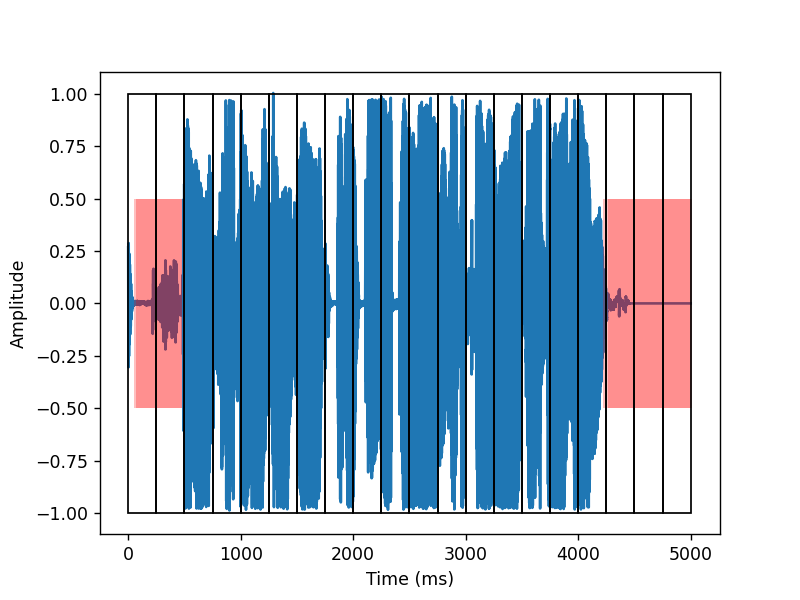

startUs: 52689
endUs: 476677
transformer {
  silenceDurationUs: 200000
}

startUs: 71982
endUs: 475609
transformer {
  silenceDurationUs: 184318
}

startUs: 4221747
endUs: 5009738
transformer {
  silenceDurationUs: 10736
}

startUs: 4268026
endUs: 5000030
transformer {
}



<IPython.core.display.Javascript object>


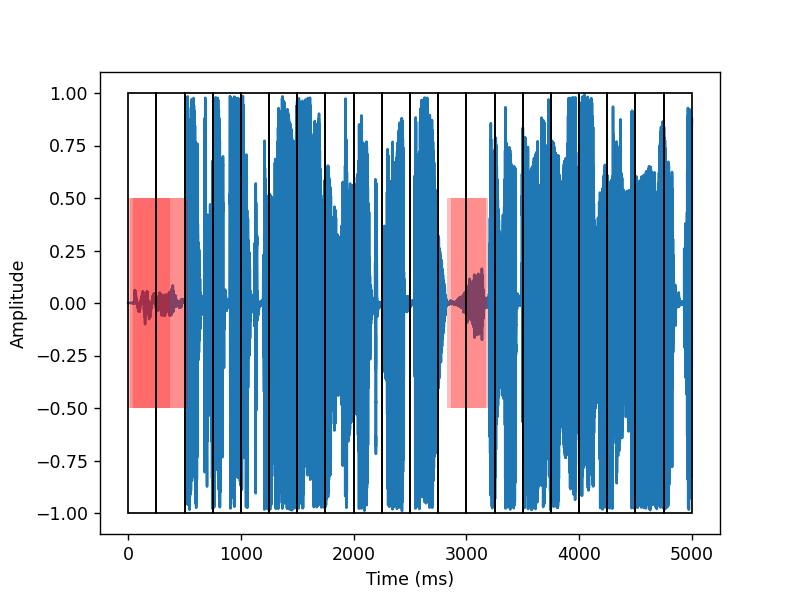

endUs: 503999
transformer {
}

startUs: 12271
endUs: 532908
transformer {
  silenceDurationUs: 110301
}

startUs: 45637
endUs: 373252
transformer {
  silenceDurationUs: 114643
}

startUs: 2828011
endUs: 3192014
transformer {
  silenceDurationUs: 150000
}

startUs: 2860644
endUs: 3170431
transformer {
  silenceDurationUs: 218680
}



In [39]:
if is_data():
    data_indexes = [i for i in range(0, 4)]
    for data_index in data_indexes:
        predicted = model.predict(tf.constant([data[data_index][0]]))[0]
        plot_data(data[data_index][0], num_grid_cells, (1, 0, 0), predicted, data[data_index][1])

In [ ]:
model.optimizer.learning_rate.assign(0.001)

In [38]:
model.load_weights(os.path.join(train_results_filepath, '7_2_cpt.h5'))

In [ ]:
model.save(os.path.join(train_results_filepath, '7_1.h5'))

In [ ]:
yolo_loss.set_lambdas({
    'l_start': 10.0, 'l_duration': 10.0, 'l_isobj': 1.0, 
    'l_noobj': 0.5, 'l_class': 10.0
})

In [ ]:
tf.data.experimental.save(train_source_dataset, os.path.join(data_path, 'train_ds_enc_' + yolo_encoding_type.lower()))
print('saved train dataset')
tf.data.experimental.save(val_source_dataset, os.path.join(data_path, 'validation_ds_enc_' + yolo_encoding_type.lower()))
print('saved validation dataset')

<IPython.core.display.Javascript object>


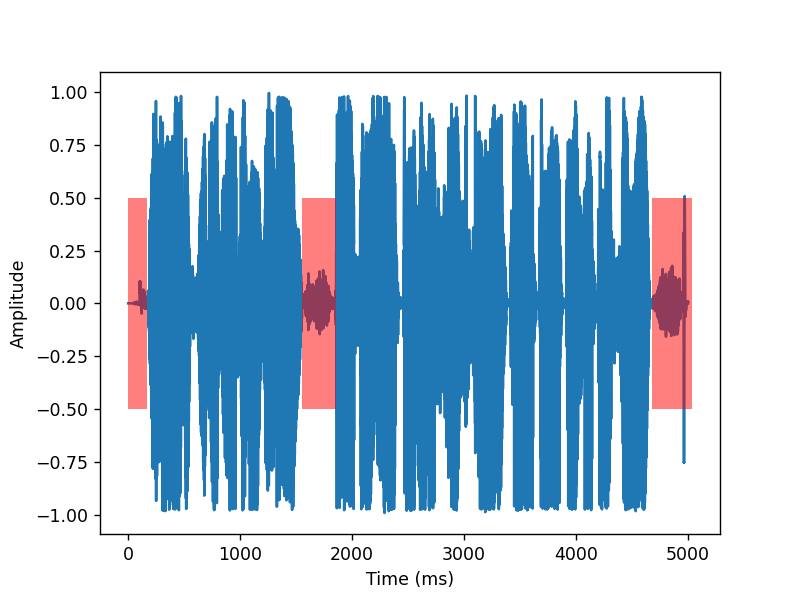

endUs: 167989
transformer {
}

startUs: 1551987
endUs: 1852005
transformer {
  silenceDurationUs: 200000
}

startUs: 4674583
endUs: 5034587
transformer {
  silenceDurationUs: 200000
}

(513, 10238)


<IPython.core.display.Javascript object>


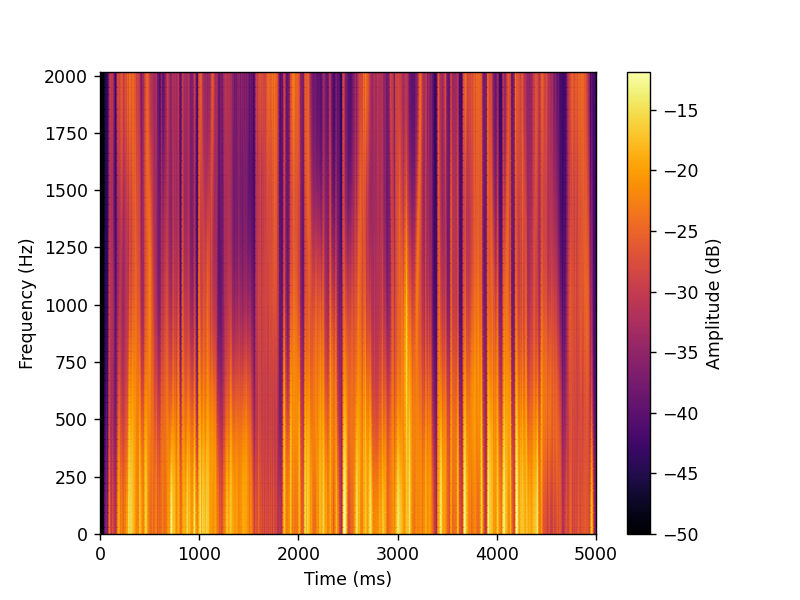

<IPython.core.display.Javascript object>


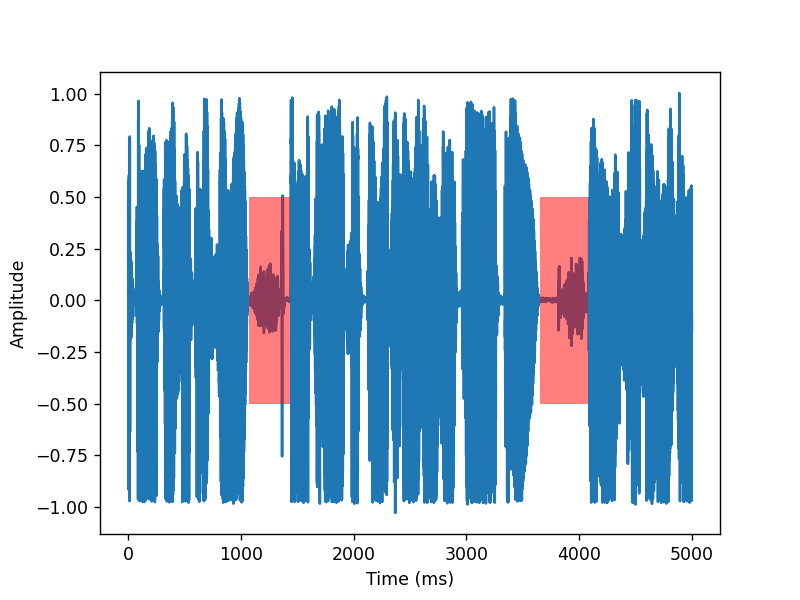

startUs: 1075004
endUs: 1435008
transformer {
  silenceDurationUs: 200000
}

startUs: 3652268
endUs: 4076256
transformer {
  silenceDurationUs: 200000
}

(513, 10238)


<IPython.core.display.Javascript object>


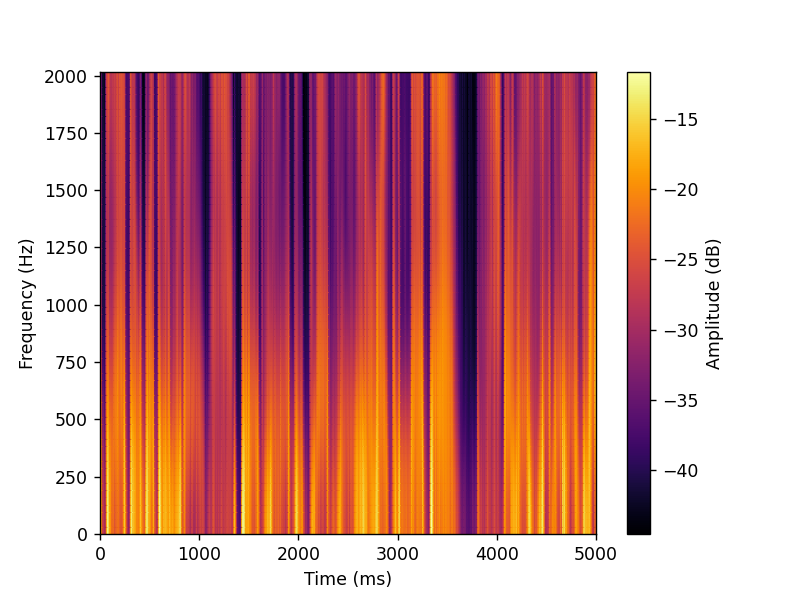

<IPython.core.display.Javascript object>


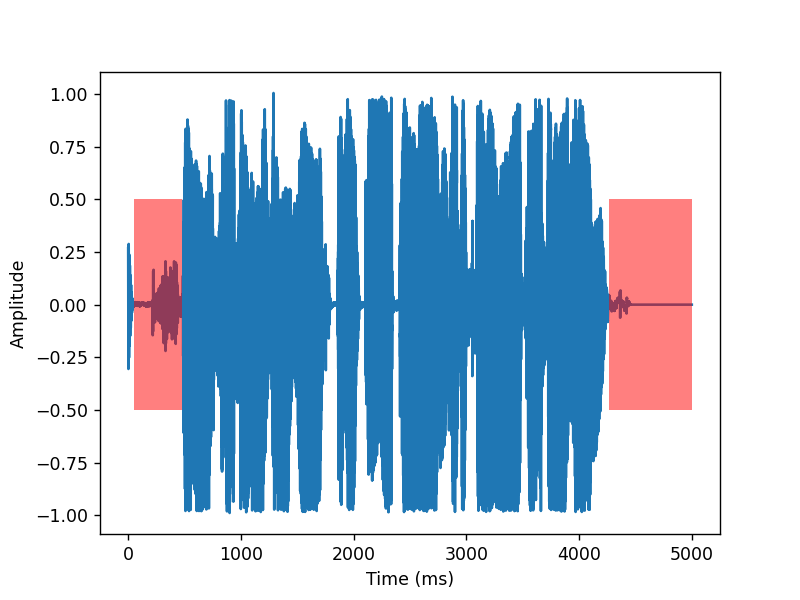

startUs: 52689
endUs: 476677
transformer {
  silenceDurationUs: 200000
}

startUs: 4268026
endUs: 5000030
transformer {
}

(513, 10238)


<IPython.core.display.Javascript object>


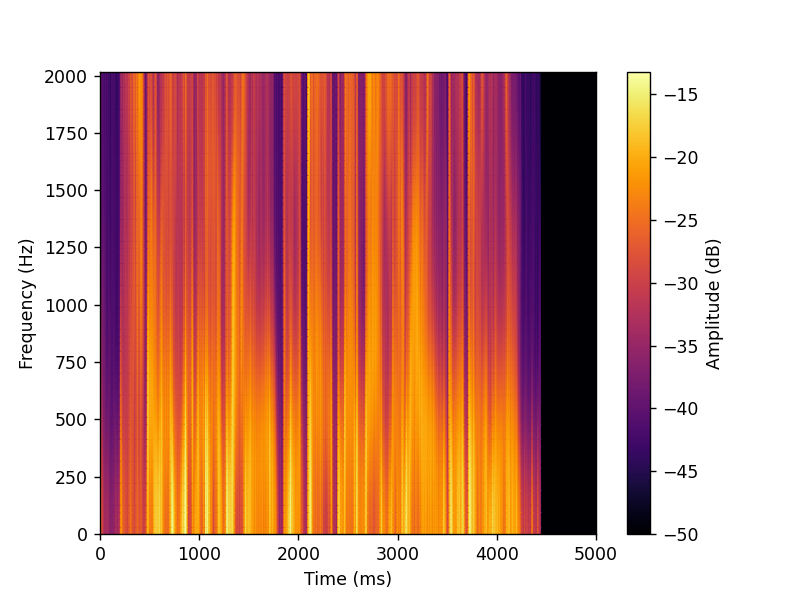

In [6]:
if is_data():
    data_indexes = [i for i in range(0, 3)]
    for data_index in data_indexes:
        plot_data(data[data_index][0], 0, (1, 0, 0), data[data_index][1])
        plot_stft(data[data_index][0], sample_rate)

In [14]:
model.layers[6].weights

[<tf.Variable 'conv2d/kernel:0' shape=(1, 63, 1, 1) dtype=float32, numpy=
 array([[[[ 0.17893773]],
 
         [[-0.19728473]],
 
         [[-0.04158767]],
 
         [[-0.08511898]],
 
         [[-0.02352286]],
 
         [[ 0.05390049]],
 
         [[-0.05269633]],
 
         [[ 0.10276233]],
 
         [[-0.21668078]],
 
         [[-0.06864283]],
 
         [[-0.16304216]],
 
         [[ 0.03778575]],
 
         [[-0.18546186]],
 
         [[ 0.05540081]],
 
         [[ 0.18556264]],
 
         [[ 0.10720109]],
 
         [[ 0.03995086]],
 
         [[-0.0545986 ]],
 
         [[-0.010356  ]],
 
         [[ 0.04650188]],
 
         [[ 0.13395047]],
 
         [[ 0.01867391]],
 
         [[ 0.08402895]],
 
         [[ 0.20639527]],
 
         [[ 0.15348497]],
 
         [[ 0.24218492]],
 
         [[-0.18136945]],
 
         [[-0.06807128]],
 
         [[-0.07909542]],
 
         [[ 0.01856618]],
 
         [[ 0.07578626]],
 
         [[-0.19253156]],
 
         [[ 0.14829643]],
 
  